## Neural Networks - Bank Churn Prediction

**Background and Context**

Businesses like banks that provide service have to worry about the problem of 'Churn' i.e. customers leaving and joining another service provider. It is important to understand which aspects of the service influence a customer's decision in this regard. Management can concentrate efforts on the improvement of service, keeping in mind these priorities.

**Objective**

Given a Bank customer, build a neural network-based classifier that can determine whether they will leave or not in the next 6 months.

**Data Description**

The case study is from an open-source dataset from Kaggle. The dataset contains 10,000 sample points with 14 distinct features such as CustomerId, CreditScore, Geography, Gender, Age, Tenure, Balance, etc.

**Data Dictionary**

- CustomerId: Unique ID which is assigned to each customer
- Surname: Last name of the customer 
- CreditScore: It defines the credit history of the customer.  
- Geography: A customer’s location    
- Gender: It defines the Gender of the customer   
- Age: Age of the customer     
- Tenure: Number of years for which the customer has been with the bank
- NumOfProducts: It refers to the number of products that a customer has purchased through the bank.
- Balance: Account balance
- HasCrCard: It is a categorical variable that decides whether the customer has a credit card or not.
- EstimatedSalary: Estimated salary 
- isActiveMember: It is a categorical variable that decides whether the customer is an active member of the bank or not ( Active - member in the sense, using bank products regularly, making transactions, etc )
- Excited: It is a categorical variable that decides whether the customer left the bank within six months or not. It can take two values:
    - 0=No ( Customer did not leave the bank )
    - 1=Yes ( Customer left the bank )

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers
from sklearn.decomposition import PCA
import seaborn as sns
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pandas_profiling

#importing tensorflow
import tensorflow as tf
print(tf.__version__)



2.6.0


## Importing data

In [2]:
#reading dataset
df = pd.read_csv('../../data/bank.csv')

### Overview of the dataset

In [3]:
df.head()

RowNumber  CustomerId   Surname  CreditScore Geography  Gender  Age  \
0          1    15634602  Hargrave          619    France  Female   42   
1          2    15647311      Hill          608     Spain  Female   41   
2          3    15619304      Onio          502    France  Female   42   
3          4    15701354      Boni          699    France  Female   39   
4          5    15737888  Mitchell          850     Spain  Female   43   

   Tenure    Balance  NumOfProducts  HasCrCard  IsActiveMember  \
0       2       0.00              1          1               1   
1       1   83807.86              1          0               1   
2       8  159660.80              3          1               0   
3       1       0.00              2          0               0   
4       2  125510.82              1          1               1   

   EstimatedSalary  Exited  
0        101348.88       1  
1        112542.58       0  
2        113931.57       1  
3         93826.63       0  
4         79084.10       0

In [4]:
wholeReport = pandas_profiling.ProfileReport(df).to_file("wholeReport.html")
pandas_profiling.ProfileReport(df)

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/27 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

# Univariate Analysis
## Pandas-profiling Report Review											

RowNumber:
Not useful, will be dropped

CustomerId:
Not useful, will be dropped

Surname:
Not useful, will be dropped

Age:
Distribution is relatively skewed with a measure of 1.01. Avg. is 38.9 years, and median is 37 years.  Only about 0% missing, inner quartile range is about 12 years.  CV is about 26%.

CreditScore:
Distribution is slightly left skewed with a measure of -.07. Avg. is 652, and median is 650 years.  0% missing, inner quartile range is about 134 points.  CV is about 14.9%.

Geography:
France is the most frequent geography, with Germany and Spain close in terms of count.  Will OHE.

Gender:
55% male, 45% female.  No missing value issue, will OHE.

Tenure:
Dstribution isn't skewed. Avg. is 5.0 years, and median is 5 years.  About 4% take a value of 0, inner quartile range is about 4 years.  CV is about 57%.

Balance:
Distribution is relatively skewed with a measure of -.14, though this is due to the large number of 0 values. Avg. is 76485, and median is 97198.  About 36% are 0, inner quartile range is about 127644.  CV is about 82%.

NumOfProducts:
Most customers have either 1 or 2 products.  No issues with 0s or missing values.

HasCrCard:
70% have a card while 30% don't.  No issues with 0s or missing values.

IsActiveMember:
51% have a card while 49% don't.  No issues with 0s or missing values.

EstimatedSalary:
Distribution is relatively flat. Avg. is 100k, and median is 100k.  No missing value issue, inner quartile range is about 100k.  CV is about 57%.

Exited:
Target variable. 20% conversion.

### OHC some vars

In [5]:
ohe_list = [['Geography'],['Gender']]
for att in ohe_list:
    df = pd.concat([df,pd.get_dummies(df[att].astype(str), drop_first=True)],axis=1)

### Drop some vars

In [6]:
df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Geography', 'Gender'], inplace = True)
df['churn'] = df['Exited']
df.drop(columns=['Exited'], inplace = True)

### Let's check the missing values

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  int64  
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Geography_Germany  10000 non-null  uint8  
 9   Geography_Spain    10000 non-null  uint8  
 10  Gender_Male        10000 non-null  uint8  
 11  churn              10000 non-null  int64  
dtypes: float64(2), int64(7), uint8(3)
memory usage: 732.5 KB


* This shows that there are 10000 instances and 13 attributes including the exited attribute.
*  As you can see there are no null values in any of the column

In [8]:
#Number of distinct categories or classes i.e., Fraudulent and Genuine
df['churn'].nunique()

2

In [9]:
#checking the percentage of each class in the dataset
(df.churn.value_counts())/(df.churn.count())

0    0.7963
1    0.2037
Name: churn, dtype: float64

* This shows an imbalance of classes. There are 79.6% 'non-exited' (0) instances and 20.4% 'exited' (1) instances. This means that we are aiming to predict less frequent events.

In [10]:
print("*********Losses due to fraud:************\n")
print("Total amount lost to churn")
print(df.Balance[df.churn == 1].sum())
print("Mean amount per churn transaction")
print(df.Balance[df.churn == 1].mean())
print("Compare to normal transactions:")
print("Total amount from non-exited")
print(df.Balance[df.churn == 0].sum())
print("Mean amount per non-exited")
print(df.Balance[df.churn == 0].mean())

*********Losses due to fraud:************

Total amount lost to churn
185588094.63
Mean amount per churn transaction
91108.53933726063
Compare to normal transactions:
Total amount from non-exited
579270798.25
Mean amount per non-exited
72745.29677885193


## Let's Explore the data 

<AxesSubplot:>

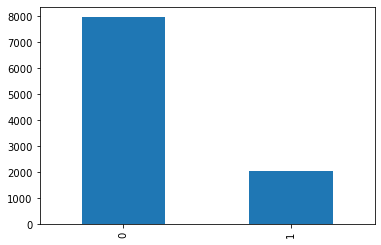

In [11]:
#visual representation of instances per class
df.churn.value_counts().plot.bar()

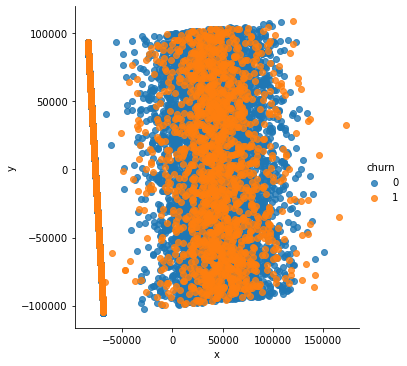

In [12]:
#PCA is performed for visualization only

pca= PCA(n_components=2)
churn_2d= pd.DataFrame(data = pca.fit_transform(df))
churn_2d= pd.concat([churn_2d, df['churn']], axis=1)
churn_2d.columns= ['x', 'y', 'churn']
sns.lmplot(x='x', y='y', data=churn_2d, fit_reg=False, hue='churn')

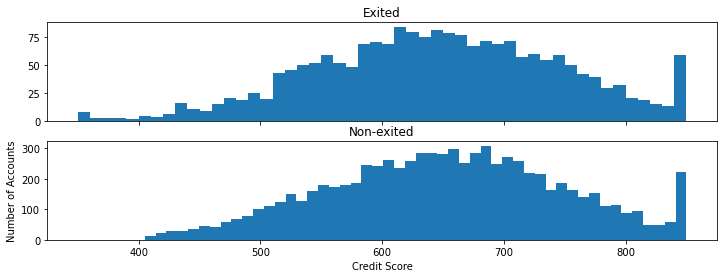

In [13]:
#Histrogram for feature Time
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))

ax1.hist(df["CreditScore"][df["churn"] == 1], bins = 50)
ax1.set_title('Exited')

ax2.hist(df["CreditScore"][df["churn"] == 0], bins = 50)
ax2.set_title('Non-exited')

plt.xlabel('Credit Score')
plt.ylabel('Number of Accounts')
plt.show()

Checking correlation between features and the likelihood of the transaction to be fraud on the unbalanced dataset

Text(0.5, 1.0, 'Correlation Matrix')

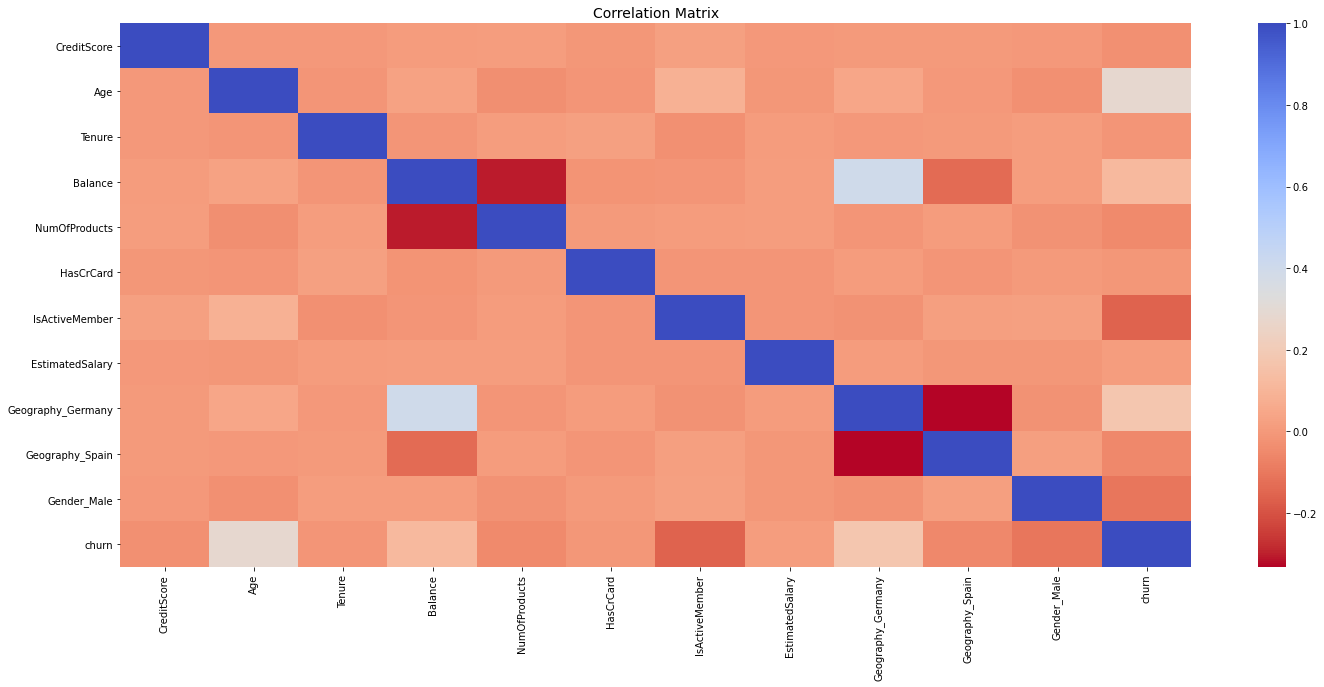

In [14]:
f, ax1 = plt.subplots(figsize=(24,10))

corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Correlation Matrix", fontsize=14)

### Separating response variable and predictors

In [15]:
X_data = df.iloc[:,0:11]
y_data = df.iloc[:, -1]

In [16]:
print(y_data.shape)
print(X_data.shape)

(10000,)
(10000, 11)


In [17]:
X_data

CreditScore  Age  Tenure    Balance  NumOfProducts  HasCrCard  \
0             619   42       2       0.00              1          1   
1             608   41       1   83807.86              1          0   
2             502   42       8  159660.80              3          1   
3             699   39       1       0.00              2          0   
4             850   43       2  125510.82              1          1   
...           ...  ...     ...        ...            ...        ...   
9995          771   39       5       0.00              2          1   
9996          516   35      10   57369.61              1          1   
9997          709   36       7       0.00              1          0   
9998          772   42       3   75075.31              2          1   
9999          792   28       4  130142.79              1          1   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
0                  1        101348.88                  0                0   
1                  1        112542.58                  0                1   
2                  0        113931.57                  0                0   
3                  0         93826.63                  0                0   
4                  1         79084.10                  0                1   
...              ...              ...                ...              ...   
9995               0         96270.64                  0                0   
9996               1        101699.77                  0                0   
9997               1         42085.58                  0                0   
9998               0         92888.52                  1                0   
9999               0         38190.78                  0                0   

      Gender_Male  
0               0  
1               0  
2               0  
3               0  
4               0  
...           ...  
9995            1  
9996            1  
9997            0  
9998            1  
9999            0  

[10000 rows x 11 columns]

In [18]:
y_data

0       1
1       0
2       1
3       0
4       0
       ..
9995    0
9996    0
9997    1
9998    1
9999    0
Name: churn, Length: 10000, dtype: int64

### Splitting the Data into train and test set

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 7)

In [20]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [21]:
print(X_train_over.shape)
print(X_test.shape)
print(y_train_over.shape)
print(y_test.shape)

print()
print("After UpSampling, counts of label 'Yes': {}".format(sum(y_train_over==1)))
print("After UpSampling, counts of label 'No': {} \n".format(sum(y_train_over==0)))


print('After UpSampling, the shape of train_X: {}'.format(X_train_over.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_over.shape))

(12748, 11)
(2000, 11)
(12748,)
(2000,)

After UpSampling, counts of label 'Yes': 6374
After UpSampling, counts of label 'No': 6374 

After UpSampling, the shape of train_X: (12748, 11)
After UpSampling, the shape of train_y: (12748,) 



## Model Building

In [22]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model,flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list=[] 
    
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    
    train_acc = model.score(X_train,y_train)
    test_acc = model.score(X_test,y_test)
    
    train_recall = metrics.recall_score(y_train,pred_train)
    test_recall = metrics.recall_score(y_test,pred_test)
    
    train_precision = metrics.precision_score(y_train,pred_train)
    test_precision = metrics.precision_score(y_test,pred_test)
    
    train_rocAuc = roc_auc_score(y_train, pred_train)
    test_rocAuc = roc_auc_score(y_test, pred_test)
    
    score_list.extend((train_acc,test_acc,train_recall,test_recall,train_precision,test_precision, train_rocAuc, test_rocAuc))
        
    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True: 
        print("Accuracy on training set : ",model.score(X_train,y_train))
        print("Accuracy on test set : ",model.score(X_test,y_test))
        print("Recall on training set : ",metrics.recall_score(y_train,pred_train))
        print("Recall on test set : ",metrics.recall_score(y_test,pred_test))
        print("Precision on training set : ",metrics.precision_score(y_train,pred_train))
        print("Precision on test set : ",metrics.precision_score(y_test,pred_test))
        print('ROC-AUC Score on train data:',metrics.roc_auc_score(y_train, pred_train))
        print('ROC-AUC Score on test data:',metrics.roc_auc_score(y_test, pred_test))
    
    return score_list # returning the list with train and test scores

In [23]:
### Function to make confusion matrix
def make_confusion_matrix(model,y_actual,labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm=metrics.confusion_matrix( y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(cm, index = [i for i in ["Actual - No","Actual - Yes"]],
                  columns = [i for i in ['Predicted - No','Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=labels,fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

## Decision Tree

Accuracy on training set :  0.695875
Accuracy on test set :  0.6835
Recall on training set :  0.7300123001230012
Recall on test set :  0.7396593673965937
Precision on training set :  0.3731530965105313
Precision on test set :  0.36626506024096384
ROC-AUC Score on train data: 0.7085894572469413
ROC-AUC Score on test data: 0.7043167825025761


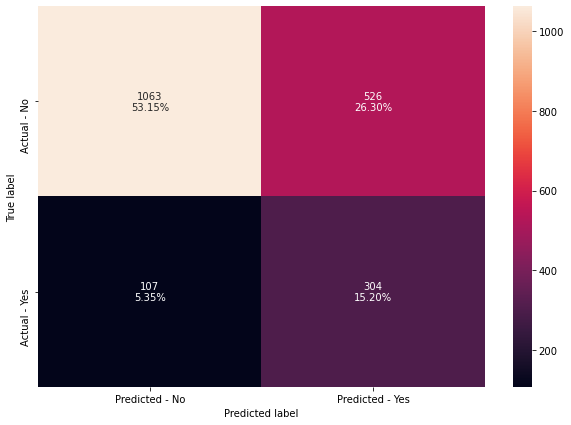

In [25]:
# Choose the type of classifier. 
estimator = DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from

parameters = {'max_depth': np.arange(1,10), 
              'min_samples_leaf': [1, 2, 5, 7, 10,15,20],
              'max_leaf_nodes' : [5, 10,15,20,25,30],
              'min_impurity_decrease': [0.0001,0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.recall_score)

# Run the grid search
grid_obj = GridSearchCV(estimator, parameters, scoring=acc_scorer,cv=5)
grid_obj = grid_obj.fit(X_train_over, y_train_over)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
estimator.fit(X_train_over, y_train_over)

#Calculating different metrics
get_metrics_score(estimator)

#Creating confusion matrix
make_confusion_matrix(estimator,y_test)

## Model evaluation criterion

### Model can make wrong predictions as:
* Predicting an account will exit but doesn't
* Predicting an account won't exit but does

### Which case is more important?
* Depends on cost associated with customer retention efforts.  Since there is no indication in the instruction as to this cost, we'll assume it isn't material here.

### How to reduce this loss i.e need to reduce False Negative?
* Company would want `Recall` to be maximized, greater the Recall higher the chances of minimizing false Negative. Hence, the focus should be on increasing Recall or minimizing the false Negative or in other words identifying the True Positive(i.e. Class 1) so that the Company can identify the churn accounts.

## Let's now explore Neural Network models

## Data Pre-processing
### Start with standardizing columns

In [26]:
#Standardizing the Amount column (All other 'V' columns are already scaled as they've undergone PCA transformation).
from sklearn.preprocessing import StandardScaler
features = list(X_data.columns)
print(features)

# Separating out the features
x = df.loc[:, features].values
# Separating out the target
y = df.loc[:,['churn']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

X_data = pd.DataFrame(x, columns = features)
y_Data = pd.DataFrame(y, columns = ['churn'])

#Xt_data[list(X_data.columns)].values = StandardScaler().fit_transform(X_data[list(X_data.columns)].values)
#Xt_data= Xt_data.drop(['Amount'],axis=1)

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Geography_Germany', 'Geography_Spain', 'Gender_Male']


In [27]:
X_data

CreditScore       Age    Tenure   Balance  NumOfProducts  HasCrCard  \
0       -0.326221  0.293517 -1.041760 -1.225848      -0.911583   0.646092   
1       -0.440036  0.198164 -1.387538  0.117350      -0.911583  -1.547768   
2       -1.536794  0.293517  1.032908  1.333053       2.527057   0.646092   
3        0.501521  0.007457 -1.387538 -1.225848       0.807737  -1.547768   
4        2.063884  0.388871 -1.041760  0.785728      -0.911583   0.646092   
...           ...       ...       ...       ...            ...        ...   
9995     1.246488  0.007457 -0.004426 -1.225848       0.807737   0.646092   
9996    -1.391939 -0.373958  1.724464 -0.306379      -0.911583   0.646092   
9997     0.604988 -0.278604  0.687130 -1.225848      -0.911583  -1.547768   
9998     1.256835  0.293517 -0.695982 -0.022608       0.807737   0.646092   
9999     1.463771 -1.041433 -0.350204  0.859965      -0.911583   0.646092   

      IsActiveMember  EstimatedSalary  Geography_Germany  Geography_Spain  \
0           0.970243         0.021886          -0.578736        -0.573809   
1           0.970243         0.216534          -0.578736         1.742740   
2          -1.030670         0.240687          -0.578736        -0.573809   
3          -1.030670        -0.108918          -0.578736        -0.573809   
4           0.970243        -0.365276          -0.578736         1.742740   
...              ...              ...                ...              ...   
9995       -1.030670        -0.066419          -0.578736        -0.573809   
9996        0.970243         0.027988          -0.578736        -0.573809   
9997        0.970243        -1.008643          -0.578736        -0.573809   
9998       -1.030670        -0.125231           1.727904        -0.573809   
9999       -1.030670        -1.076370          -0.578736        -0.573809   

      Gender_Male  
0       -1.095988  
1       -1.095988  
2       -1.095988  
3       -1.095988  
4       -1.095988  
...           ...  
9995     0.912419  
9996     0.912419  
9997    -1.095988  
9998     0.912419  
9999    -1.095988  

[10000 rows x 11 columns]

### Standardize the data

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size = 0.2, random_state = 7)

In [29]:
sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [30]:
print()
print("After UpSampling, counts of label 'Yes': {}".format(sum(y_train_over==1)))
print("After UpSampling, counts of label 'No': {} \n".format(sum(y_train_over==0)))


print('After UpSampling, the shape of train_X: {}'.format(X_train_over.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_over.shape))


After UpSampling, counts of label 'Yes': 6374
After UpSampling, counts of label 'No': 6374 

After UpSampling, the shape of train_X: (12748, 11)
After UpSampling, the shape of train_y: (12748,) 



## Deep neural network

Model-1 

- We will use a simple NN made of 5 fully-connected layers with ReLu activation. The NN takes a vector of length 29 as input. This represents the information related to each transactions, ie each line with 29 columns from the dataset. For each transaction, the final layer will output a probability distribution (sigmoid activation function) and classify either as not fraudulent (0) or fraudulent (1).
- a dropout step is included to prevent overfitting.



**Dropout**

Dropout is a regularization technique for neural network models proposed by Srivastava, et al. in their 2014 paper Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly.

### Creating a model

Keras model object can be created with Sequential class

At the outset, the model is empty per se. It is completed by adding additional layers and compilation


In [31]:
#initialize the model
model = Sequential()

### Adding layers [layers and activations]

Keras layers can be added to the model

Adding layers are like stacking lego blocks one by one

It should be noted that as this is a classification problem, sigmoid layer (softmax for multi-class problems) should be added


In [32]:
# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
model.add(Dense(units=6, input_dim = 11,activation='relu'))   # input of 29 columns as shown above
# hidden layer
model.add(Dense(units=6,activation='relu'))
#Adding Dropout to prevent overfitting 
model.add(Dropout(0.5))
model.add(Dense(24,activation='relu'))
model.add(Dense(24,activation='relu'))
# Adding the output layer
# Notice that we do not need to specify input dim. 
# we have an output of 1 node, which is the the desired dimensions of our output (fraud or not)
# We use the sigmoid because we want probability outcomes
model.add(Dense(1,activation='sigmoid'))                        # binary classification fraudulent or not

### Model compile [optimizers and loss functions]

Keras model should be "compiled" prior to training

Types of loss (function) and optimizer should be designated

In [33]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Create optimizer with default learning rate
# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[recall_m])

### Let's print the summary of the model 

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                168       
_________________________________________________________________
dense_3 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 25        
Total params: 907
Trainable params: 907
Non-trainable params: 0
__________________________________________________________

## Training [Forward pass and Backpropagation]

Training the model

In [35]:
#fitting the model
history=model.fit(X_train_over,y_train_over,batch_size=10,epochs=100,validation_split=0.2)

Epoch 1/100
1020/1020 [==============================] - 2s 2ms/step - loss: 0.6500 - recall_m: 0.0537 - val_loss: 0.8545 - val_recall_m: 0.3369
Epoch 2/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.5903 - recall_m: 0.3466 - val_loss: 0.8166 - val_recall_m: 0.5090
Epoch 3/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.5649 - recall_m: 0.4272 - val_loss: 0.7585 - val_recall_m: 0.5212
Epoch 4/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.5489 - recall_m: 0.4780 - val_loss: 0.7308 - val_recall_m: 0.6588
Epoch 5/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.5352 - recall_m: 0.6406 - val_loss: 0.6986 - val_recall_m: 0.6843
Epoch 6/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.5261 - recall_m: 0.6607 - val_loss: 0.6267 - val_recall_m: 0.7188
Epoch 7/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.5134 - recall_m: 0.7103 - val_loss: 0.6120 - val_re

1020/1020 [==============================] - 1s 1ms/step - loss: 0.4587 - recall_m: 0.5730 - val_loss: 0.2393 - val_recall_m: 0.9757
Epoch 58/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.4589 - recall_m: 0.5961 - val_loss: 0.2747 - val_recall_m: 0.9557
Epoch 59/100
1020/1020 [==============================] - 1s 744us/step - loss: 0.4565 - recall_m: 0.6042 - val_loss: 0.2620 - val_recall_m: 0.9757
Epoch 60/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.4604 - recall_m: 0.5893 - val_loss: 0.2608 - val_recall_m: 0.9655
Epoch 61/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.4561 - recall_m: 0.5899 - val_loss: 0.2796 - val_recall_m: 0.9404
Epoch 62/100
1020/1020 [==============================] - 1s 837us/step - loss: 0.4546 - recall_m: 0.5857 - val_loss: 0.2538 - val_recall_m: 0.9588
Epoch 63/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.4536 - recall_m: 0.5795 - val_loss: 0.1776 - val_reca

Plotting the train and test loss

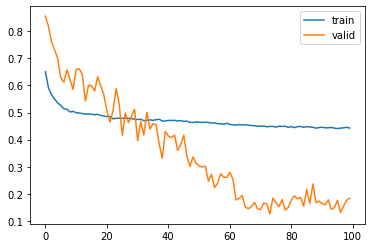

In [36]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

### Evaluation
Keras model can be evaluated with evaluate() function

Evaluation results are contained in a list

In [37]:
score = model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 2ms/step - loss: 0.9199 - recall_m: 0.9792


- The model achieves a recall of 97.9%!

In [38]:
print(score)

[0.9199440479278564, 0.979205846786499]


In [39]:

def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

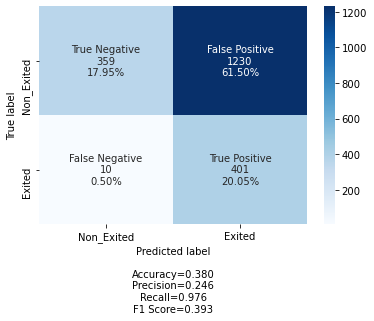

In [40]:
## Confusion Matrix on unsee test set
import seaborn as sn
y_pred1 = model.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0



cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Non_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

## NN Again - Optimize on AUC

In [41]:
#initialize the model
model = Sequential()

In [42]:
# This adds the input layer (by specifying input dimension) AND the first hidden layer (units)
model.add(Dense(units=6, input_dim = 11,activation='relu'))   # input of 29 columns as shown above
# hidden layer
model.add(Dense(units=6,activation='relu'))
#Adding Dropout to prevent overfitting 
model.add(Dropout(0.5))
model.add(Dense(24,activation='relu'))
model.add(Dense(24,activation='relu'))
# Adding the output layer
# Notice that we do not need to specify input dim. 
# we have an output of 1 node, which is the the desired dimensions of our output (fraud or not)
# We use the sigmoid because we want probability outcomes
model.add(Dense(1,activation='sigmoid'))                        # binary classification fraudulent or not

In [44]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Create optimizer with default learning rate
# Compile the model
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=[tf.keras.metrics.AUC()])

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 42        
_________________________________________________________________
dropout_1 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 24)                168       
_________________________________________________________________
dense_8 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 25        
Total params: 907
Trainable params: 907
Non-trainable params: 0
________________________________________________________

In [46]:
#fitting the model
history=model.fit(X_train_over,y_train_over,batch_size=10,epochs=100,validation_split=0.2)

Epoch 1/100
1020/1020 [==============================] - 2s 1ms/step - loss: 0.6285 - auc: 0.6442 - val_loss: 0.7816 - val_auc: 0.0000e+00
Epoch 2/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.5640 - auc: 0.7546 - val_loss: 0.6953 - val_auc: 0.0000e+00
Epoch 3/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.5365 - auc: 0.7844 - val_loss: 0.6498 - val_auc: 0.0000e+00
Epoch 4/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.5238 - auc: 0.7975 - val_loss: 0.6002 - val_auc: 0.0000e+00
Epoch 5/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.5091 - auc: 0.8110 - val_loss: 0.5654 - val_auc: 0.0000e+00
Epoch 6/100
1020/1020 [==============================] - 1s 1ms/step - loss: 0.4998 - auc: 0.8179 - val_loss: 0.5661 - val_auc: 0.0000e+00
Epoch 7/100
1020/1020 [==============================] - 1s 975us/step - loss: 0.4898 - auc: 0.8274 - val_loss: 0.5340 - val_auc: 0.0000e+00
Epoch 8/100
1020/1020 [==

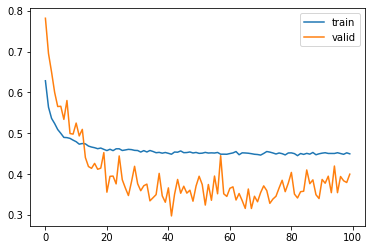

In [47]:
# Capturing learning history per epoch
hist  = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Plotting accuracy at different epochs
plt.plot(hist['loss'])
plt.plot(hist['val_loss'])
plt.legend(("train" , "valid") , loc =0)

In [48]:
score = model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 1ms/step - loss: 0.5484 - auc: 0.8513


In [49]:
print(score)

[0.5483859181404114, 0.851285994052887]


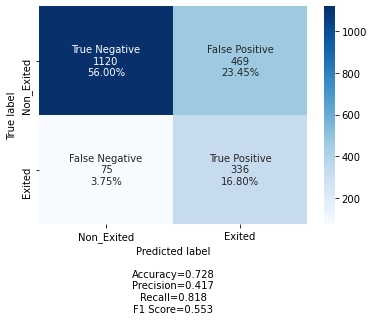

In [50]:
## Confusion Matrix on unsee test set
import seaborn as sn
y_pred1 = model.predict(X_test)
for i in range(len(y_test)):
    if y_pred1[i]>0.5:
        y_pred1[i]=1 
    else:
        y_pred1[i]=0



cm2=confusion_matrix(y_test, y_pred1)
labels = ['True Negative','False Positive','False Negative','True Positive']
categories = [ 'Non_Exited','Exited']
make_confusion_matrix(cm2, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

## Conclusion

When focusing on recall as the target metric the Decision Tree model gives us better results as compared to the Neural Network model which has really poor performance in terms of false positives.  However, when focusing on AUC-ROC as in the second iteration of the Neural Network, we actually end up with a much more balanced model.  The final model has not only improved over the decision tree from the AUC-ROC stat, but recall as well.